In [1]:
%%capture
!pip install "cvxpy[OSQP]"

!git clone https://github.com/shaoanlu/pyNMPC.git
%cd pyNMPC

In [2]:
from pyNMPC.nmhe import NMHE, MHEResult, MHEParams

/usr/local/lib/python3.11/dist-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


Solve time: 2.3531317710876465


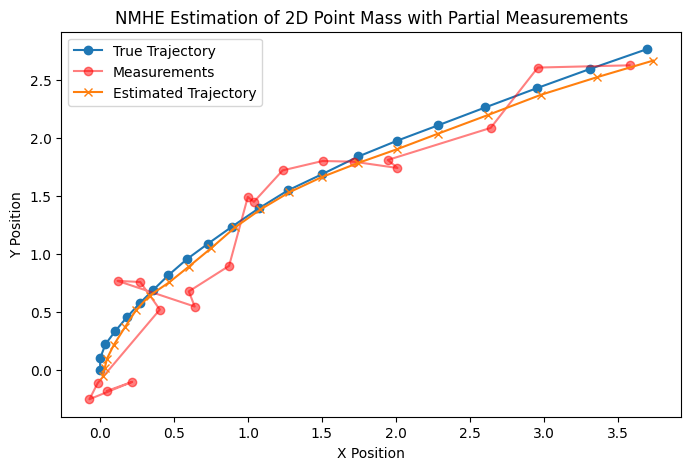

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
import time

# Assume NMHE, MHEParams, MHEResult are already imported as defined earlier

# ---------- 1. Define Dynamics and Output Functions ----------

def dynamics(x, u, dt):
    """Simple point mass dynamics"""
    p, v = x[:2], x[2:]
    p_next = p + v * dt
    v_next = v + u * dt
    return jnp.concatenate([p_next, v_next])

# def dynamics(x: jnp.ndarray, u: jnp.ndarray, dt: float) -> jnp.ndarray:
#     """Unicycle dynamics model."""
#     theta = x[2]
#     return x + jnp.array([u[0] * jnp.cos(theta), u[0] * jnp.sin(theta), u[1]]) * dt

def output_fn(x):
    """Measure only position"""
    return x[:2]  # Only position (px, py)

# ---------- 2. Define NMHE Parameters ----------

dt = 0.1
N = 20  # Estimation horizon
n_states = 4
n_controls = 2
n_outputs = 2  # We only observe positions

params = MHEParams(
    dt=dt,
    N=N,
    n_states=n_states,
    n_controls=n_controls,
    n_outputs=n_outputs,
    n_est_params=0,
    Q=1.0 * jnp.eye(n_states),  # Process noise penalty
    R=0.1 * jnp.eye(n_outputs),  # Measurement fitting weight
    Px=1.0 * jnp.eye(n_states),
    Pp=1.0 * jnp.eye(n_outputs),
    u_min=-2 * jnp.ones(n_controls),
    u_max=2 * jnp.ones(n_controls),
    max_sqp_iter=5,
    sqp_tol=1e-4,
    verbose=False,
)

# ---------- 3. Instantiate NMHE ----------

nmhe = NMHE(dynamics_fn=dynamics, output_fn=output_fn, params=params)

# ---------- 4. Generate Synthetic Data ----------
rng = jax.random.PRNGKey(0)

# True initial state
x_true = jnp.array([0.0, 0.0, 0.0, 1.0])

# Control sequence (e.g., constant acceleration)
u_seq = jnp.tile(jnp.array([2.0, 0.1]), (N, 1))

# Simulate true trajectory
x_traj = [x_true]
for u in u_seq:
    u_noise = 1 * jax.random.normal(rng, (2,))
    x_next = dynamics(x_traj[-1], u+u_noise, dt)
    x_traj.append(x_next)
    rng, _ = jax.random.split(rng)
x_traj = jnp.stack(x_traj)

# Generate noisy measurements (only positions)
y_seq = x_traj[:N, :2] + 0.2 * jax.random.normal(rng, (N, 2))

# ---------- 5. Run NMHE ----------

# Initial guess for state
x0_guess = jnp.array([0.0, 0.0, 0.0, 1.0])

# Run estimation
result = nmhe.estimate(
    x0=x0_guess,
    u_seq=u_seq,
    y_seq=y_seq,
    prev_est=None  # No warm start
)

# ---------- 6. Print and Plot Results ----------

print(f"Solve time: {result.solve_time}")

# Optional: Plot (if matplotlib available)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(x_traj[:, 0], x_traj[:, 1], label="True Trajectory", marker='o')
plt.plot(y_seq[:, 0], y_seq[:, 1], "-o", label="Measurements", color='red', alpha=0.5)
plt.plot(result.x_est[:, 0], result.x_est[:, 1], label="Estimated Trajectory", marker='x')
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("NMHE Estimation of 2D Point Mass with Partial Measurements")
plt.show()
